In [2]:
import torch
from transformers import MarianMTModel, MarianTokenizer

from test_utils import *

import json

/Users/justin/anaconda3/envs/py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the tokenizer and model
model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)
model.eval()


/Users/justin/anaconda3/envs/py3.11/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [4]:
from datasets import load_dataset

# Load the WMT14 English-German dataset
dataset = load_dataset('wmt19', 'de-en', split='validation')


Using the latest cached version of the dataset since wmt19 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'de-en' at /Users/justin/.cache/huggingface/datasets/wmt19/de-en/0.0.0/c8a87a86736e7bf10c74c22e9033eba9146774e9 (last modified on Tue Jul 23 13:58:28 2024).


In [5]:
import random

# Sample a subset of the dataset for quicker evaluation
sample_size = 100  # Adjust as needed
sampled_dataset = dataset.shuffle(seed=42).select(range(sample_size))

# Prepare the references and generate translations
references = sampled_dataset['translation']
source_texts = [item['en'] for item in references]
target_texts = [item['de'] for item in references]


In [53]:
# Create a dictionary to store the texts
data = {
    'source_texts': source_texts,
    'target_texts': target_texts
}

# Save the dictionary to a JSON file
with open('translations.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [6]:
# Load the JSON file
with open('translations.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the source and target texts
source_texts = data['source_texts']
target_texts = data['target_texts']

In [7]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Ensure nltk is installed
nltk.download('punkt')

def compute_bleu_score(model,source_texts,target_texts):
    # Tokenize and generate translations
    generated_texts = []
    for source in source_texts:
        inputs = tokenizer.encode(source, return_tensors='pt', max_length=512, truncation=True)
        with torch.no_grad():
            translated_tokens = model.generate(inputs, max_length=512, num_beams=5, early_stopping=True)
        generated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
        generated_texts.append(generated_text)

    # Tokenize the reference and generated texts
    tokenized_references = [[nltk.word_tokenize(text)] for text in target_texts]
    tokenized_generated_texts = [nltk.word_tokenize(text) for text in generated_texts]

    # Calculate BLEU score
    smoothie = SmoothingFunction().method4
    bleu_score = corpus_bleu(tokenized_references, tokenized_generated_texts, smoothing_function=smoothie)

    return bleu_score*100


[nltk_data] Downloading package punkt to /Users/justin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
baseline_bleu = compute_bleu_score(model,source_texts,target_texts)

In [9]:
baseline_bleu

46.82103167541074

In [10]:
model.model.encoder

MarianEncoder(
  (embed_tokens): Embedding(58101, 512, padding_idx=58100)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0-5): 6 x MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): SiLU()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [11]:
atten_block = model.model.encoder.layers[0].self_attn

In [12]:
k_weight = atten_block.k_proj.weight.detach().clone().numpy()

In [13]:
k_weight

array([[-0.0431658 ,  0.05314786,  0.01992885, ...,  0.05150389,
        -0.05855705, -0.06797506],
       [ 0.03430727, -0.03185176, -0.02637685, ..., -0.00773765,
         0.03985396,  0.02887879],
       [ 0.00455057, -0.00745978,  0.09381308, ..., -0.0922135 ,
        -0.13821538, -0.01102295],
       ...,
       [-0.03620727,  0.01365876,  0.05509148, ..., -0.01048039,
         0.00950968, -0.06236786],
       [-0.02010291,  0.08748431,  0.06102307, ...,  0.04928866,
        -0.11875598,  0.09157822],
       [-0.00318049,  0.05060565, -0.01177562, ...,  0.07342083,
        -0.03669421,  0.01891214]], dtype=float32)

In [14]:
def extract_weight_array(layer):
    atten_block = layer.self_attn
    
    k_weight = atten_block.k_proj.weight.detach().clone().numpy()
    v_weight = atten_block.v_proj.weight.detach().clone().numpy()
    q_weight = atten_block.q_proj.weight.detach().clone().numpy()

    return [k_weight,v_weight,q_weight]

In [15]:
original_atten_block_weight_array_0 = extract_weight_array(model.model.encoder.layers[0])
original_atten_block_weight_array_1 = extract_weight_array(model.model.encoder.layers[1])
original_atten_block_weight_array_2 = extract_weight_array(model.model.encoder.layers[2])
original_atten_block_weight_array_3 = extract_weight_array(model.model.encoder.layers[3])
original_atten_block_weight_array_4 = extract_weight_array(model.model.encoder.layers[4])
original_atten_block_weight_array_5 = extract_weight_array(model.model.encoder.layers[5])

In [17]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)

In [18]:
baseline_bleu

46.82103167541074

In [55]:
bleu = compute_bleu_score(model,source_texts,target_texts)

In [56]:
bleu

46.82103167541074

In [51]:
import sys
sys.path.append('/Users/justin/Desktop/Imperial/Year 4/FYP/Code/main')
from iterative_approximation.Algorithm1 import *

import sys
sys.path.append('/Users/justin/Desktop/Imperial/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm
from iterative_approximation.quantizer import *

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [70]:
def set_layer_weight(layer,atten_block_weight_array,quantizer=False,precision=32):
    if quantizer:
        # print(atten_block_weight_array[0])
        # print(integer_quantize(atten_block_weight_array[0], width=precision, frac_width=precision-4, is_signed=True))
        layer.self_attn.k_proj.weight.data = torch.tensor(integer_quantize(atten_block_weight_array[0], width=precision, frac_width=precision-4, is_signed=True),dtype=torch.float32)
        layer.self_attn.v_proj.weight.data = torch.tensor(integer_quantize(atten_block_weight_array[1], width=precision, frac_width=precision-4, is_signed=True),dtype=torch.float32)
        layer.self_attn.q_proj.weight.data = torch.tensor(integer_quantize(atten_block_weight_array[2], width=precision, frac_width=precision-4, is_signed=True),dtype=torch.float32)
    else:
        layer.self_attn.k_proj.weight.data = torch.tensor(atten_block_weight_array[0],dtype=torch.float32)
        layer.self_attn.v_proj.weight.data = torch.tensor(atten_block_weight_array[1],dtype=torch.float32)
        layer.self_attn.q_proj.weight.data = torch.tensor(atten_block_weight_array[2],dtype=torch.float32)
    # layer.self_attn.q_proj.weight.data = torch.randn_like(layer.self_attn.q_proj.weight.data)

In [22]:
W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,512,512,1,1)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,512,512,1,1)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,512,512,1,1)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,512,512,1,1)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,512,512,1,1)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,512,512,1,1)

In [23]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

mse = []
bleu_scores = []

for i in range(50):
    atten_block_weight_array_0 = W0.iterative_approximation_step1()
    atten_block_weight_array_1 = W1.iterative_approximation_step1()
    atten_block_weight_array_2 = W2.iterative_approximation_step1()
    atten_block_weight_array_3 = W3.iterative_approximation_step1()
    atten_block_weight_array_4 = W4.iterative_approximation_step1()
    atten_block_weight_array_5 = W5.iterative_approximation_step1()
    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse.append(W0_MSE)

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores.append(bleu)


KeyboardInterrupt: 

In [92]:
mse

[0.018023651637322276, 0.017569384538518976, 0.017126227841415445]

In [91]:
bleu_scores

[3.5172708438923466, 4.066229357478371, 4.279874737677521]

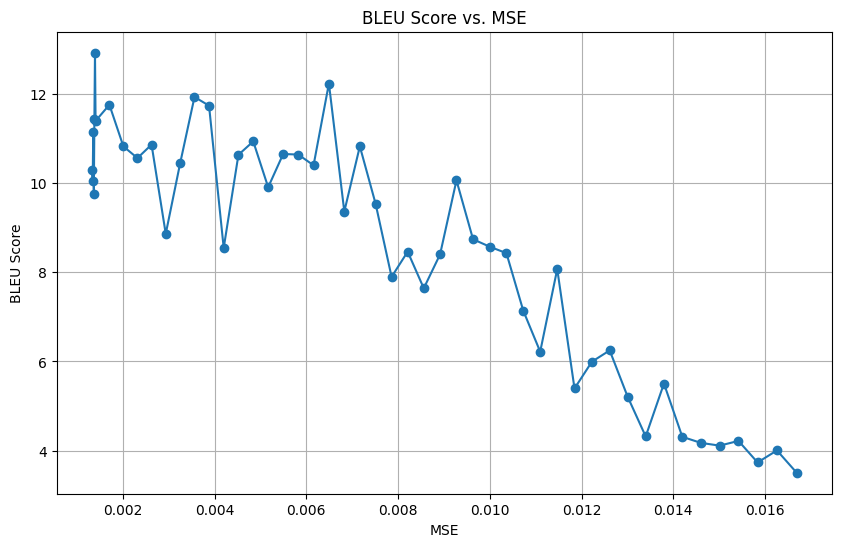

In [94]:
# Plotting BLEU against MSE
plt.figure(figsize=(10, 6))
plt.plot(mse, bleu_scores, marker='o')
plt.xlabel('MSE')
plt.ylabel('BLEU Score')
plt.title('BLEU Score vs. MSE')
plt.grid(True)
plt.show()

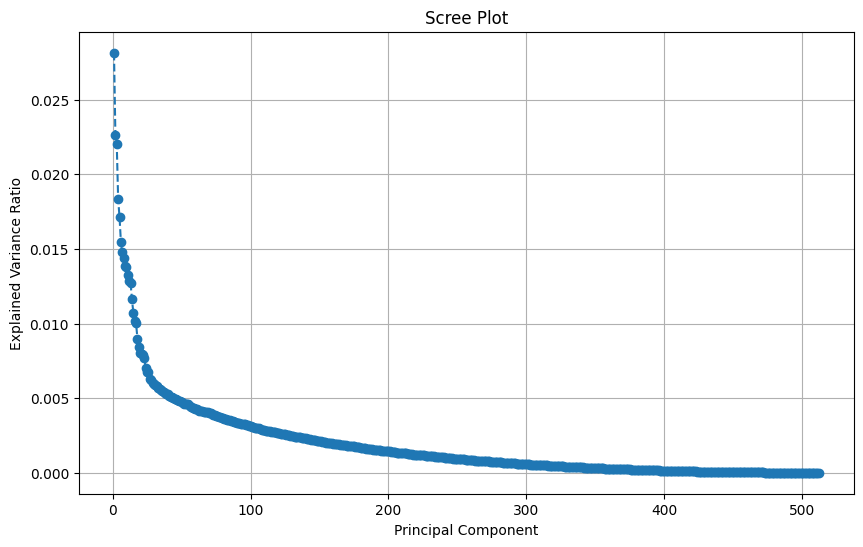

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example matrix (replace this with your actual matrix)
matrix =  model.model.encoder.layers[1].self_attn.k_proj.weight.detach().clone().numpy() # 100 samples, 10 features

# Perform PCA
pca = PCA()
pca.fit(matrix)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Create the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [24]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,1,1,512,512)

mse = []
bleu_scores = []
compression_ratio = []

for i in range(150):
        atten_block_weight_array_0 = W0.iterative_approximation_step1()
        atten_block_weight_array_1 = W1.iterative_approximation_step1()
        atten_block_weight_array_2 = W2.iterative_approximation_step1()
        atten_block_weight_array_3 = W3.iterative_approximation_step1()
        atten_block_weight_array_4 = W4.iterative_approximation_step1()
        atten_block_weight_array_5 = W5.iterative_approximation_step1()

for i in range(18):
    for i in range(5):
        atten_block_weight_array_0 = W0.iterative_approximation_step1()
        atten_block_weight_array_1 = W1.iterative_approximation_step1()
        atten_block_weight_array_2 = W2.iterative_approximation_step1()
        atten_block_weight_array_3 = W3.iterative_approximation_step1()
        atten_block_weight_array_4 = W4.iterative_approximation_step1()
        atten_block_weight_array_5 = W5.iterative_approximation_step1()

    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse.append(W0_MSE)
    compression_ratio.append(W0.compression_ratio())

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores.append(bleu)

In [34]:
np.save('mse.npy', mse)
np.save('bleu_scores.npy', bleu_scores)
np.save('compression_ratio.npy', compression_ratio)


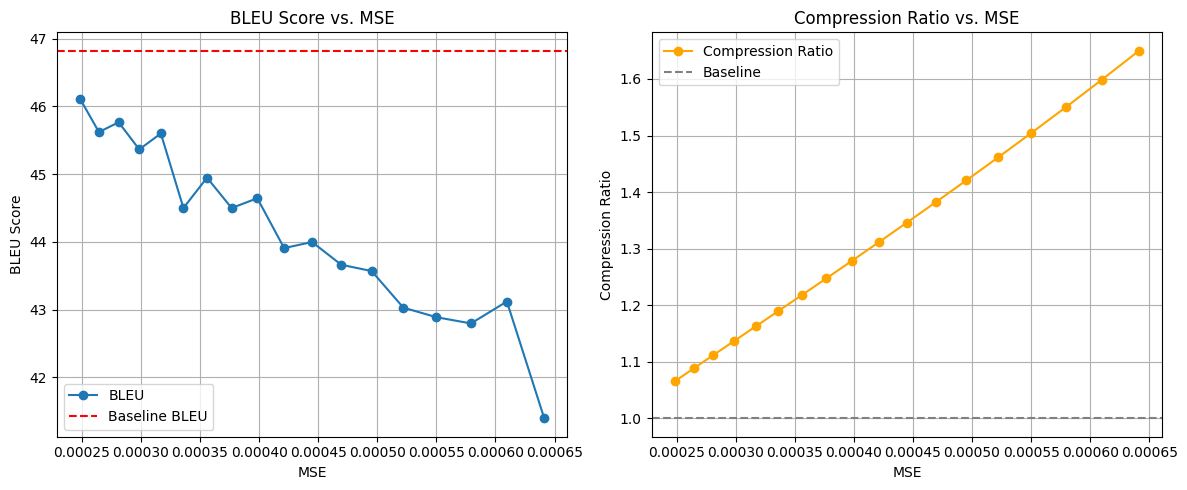

In [25]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: BLEU Score vs. MSE
axs[0].plot(mse, bleu_scores, marker='o', linestyle='-',label='BLEU')
axs[0].axhline(baseline_bleu, color='red', linestyle='--',label='Baseline BLEU')  # Add a horizontal line at y=1
axs[0].set_xlabel('MSE')
axs[0].set_ylabel('BLEU Score')
axs[0].set_title('BLEU Score vs. MSE')
axs[0].grid(True)
axs[0].legend()

# Second subplot: Compression Ratio vs. MSE
axs[1].plot(mse, compression_ratio, marker='o', linestyle='-', color='orange',label='Compression Ratio')
axs[1].axhline(1, color='gray', linestyle='--',label='Baseline')  # Add a horizontal line at y=1
axs[1].set_xlabel('MSE')
axs[1].set_ylabel('Compression Ratio')
axs[1].set_title('Compression Ratio vs. MSE')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [32]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,1,1,512,512)

mse1 = []
bleu_scores1 = []
compression_ratio1 = []

for i in range(450):
    print(i)
    atten_block_weight_array_0 = W0.iterative_approximation_step2()
    atten_block_weight_array_1 = W1.iterative_approximation_step2()
    atten_block_weight_array_2 = W2.iterative_approximation_step2()
    atten_block_weight_array_3 = W3.iterative_approximation_step2()
    atten_block_weight_array_4 = W4.iterative_approximation_step2()
    atten_block_weight_array_5 = W5.iterative_approximation_step2()

for i in range(15):
    print('eval')
    print(i)
    for j in range(20):
        atten_block_weight_array_0 = W0.iterative_approximation_step2()
        atten_block_weight_array_1 = W1.iterative_approximation_step2()
        atten_block_weight_array_2 = W2.iterative_approximation_step2()
        atten_block_weight_array_3 = W3.iterative_approximation_step2()
        atten_block_weight_array_4 = W4.iterative_approximation_step2()
        atten_block_weight_array_5 = W5.iterative_approximation_step2()

    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse1.append(W0_MSE)
    compression_ratio1.append(W0.compression_ratio())

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores1.append(bleu)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
np.save('mse1.npy', mse1)
np.save('bleu_scores1.npy', bleu_scores1)
np.save('compression_ratio1.npy', compression_ratio1)

In [40]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'weight',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'weight',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'weight',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'weight',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'weight',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'weight',0.001,1,1,512,512)


mse2 = []
bleu_scores2 = []
compression_ratio2 = []

for i in range(210):
        atten_block_weight_array_0 = W0.iterative_approximation_step3()
        atten_block_weight_array_1 = W1.iterative_approximation_step3()
        atten_block_weight_array_2 = W2.iterative_approximation_step3()
        atten_block_weight_array_3 = W3.iterative_approximation_step3()
        atten_block_weight_array_4 = W4.iterative_approximation_step3()
        atten_block_weight_array_5 = W5.iterative_approximation_step3()
        print(i)

for i in range(16):
    print('eval')
    print(i)
    for j in range(5):
        atten_block_weight_array_0 = W0.iterative_approximation_step3()
        atten_block_weight_array_1 = W1.iterative_approximation_step3()
        atten_block_weight_array_2 = W2.iterative_approximation_step3()
        atten_block_weight_array_3 = W3.iterative_approximation_step3()
        atten_block_weight_array_4 = W4.iterative_approximation_step3()
        atten_block_weight_array_5 = W5.iterative_approximation_step3()

    W0_MSE = (W0.average_mse_weight()+W1.average_mse_weight()+W2.average_mse_weight()+W3.average_mse_weight()+W4.average_mse_weight()+W5.average_mse_weight())/6
    mse2.append(W0_MSE)

    compression_ratio2.append(W0.compression_ratio())
    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores2.append(bleu)



eval
0
eval
1
eval
2
eval
3
eval
4
eval
5
eval
6


In [49]:
np.save('mse2.npy', mse2)
np.save('bleu_scores2.npy', bleu_scores2)
np.save('compression_ratio2.npy', compression_ratio2)

In [41]:
len(mse2)

27

In [37]:
len(compression_ratio2)

27

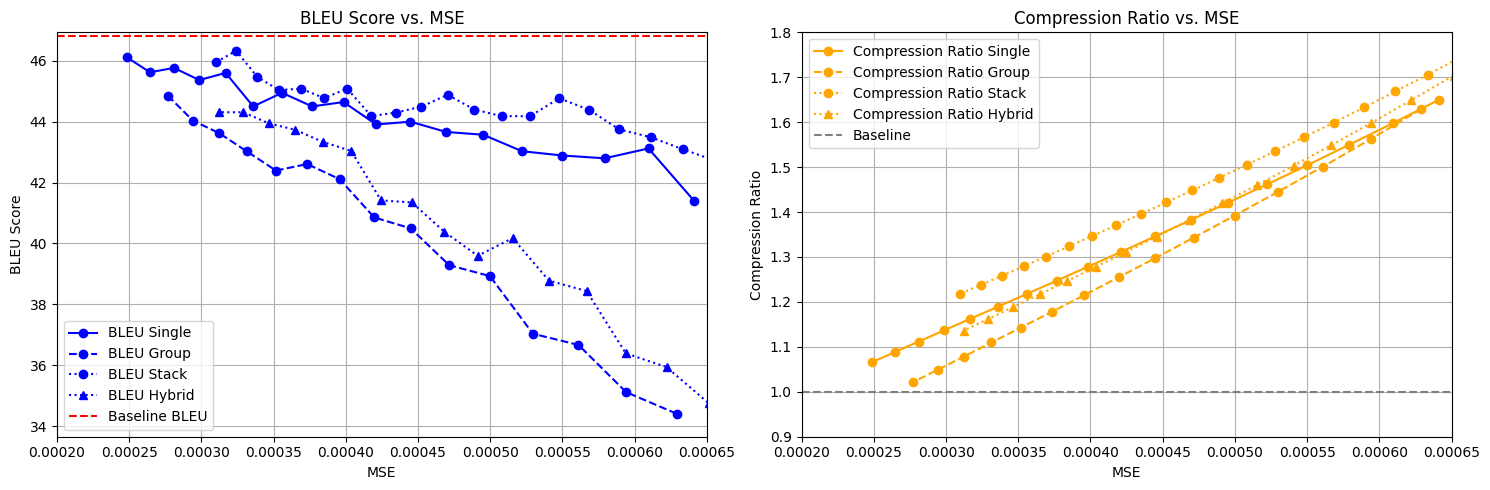

In [57]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: BLEU Score vs. MSE
axs[0].plot(mse, bleu_scores, marker='o', linestyle='-', color='blue',label='BLEU Single')
axs[0].plot(mse1, bleu_scores1, marker='o', linestyle='--', color='blue',label='BLEU Group')
axs[0].plot(mse2, bleu_scores2, marker='o', linestyle='dotted', color='blue',label='BLEU Stack')
axs[0].plot(mse3, bleu_scores3, marker='^', linestyle='dotted', color='blue',label='BLEU Hybrid')
axs[0].axhline(baseline_bleu, color='red', linestyle='--',label='Baseline BLEU')  # Add a horizontal line at y=1
axs[0].set_xlabel('MSE')
axs[0].set_ylabel('BLEU Score')
axs[0].set_title('BLEU Score vs. MSE')
axs[0].grid(True)
axs[0].set_xlim([0.0002, 0.00065])
axs[0].legend()

# Second subplot: Compression Ratio vs. MSE
axs[1].plot(mse, compression_ratio, marker='o', linestyle='-',color='orange',label='Compression Ratio Single')
axs[1].plot(mse1, compression_ratio1, marker='o', linestyle='--', color='orange',label='Compression Ratio Group')
axs[1].plot(mse2, compression_ratio2, marker='o', linestyle='dotted', color='orange',label='Compression Ratio Stack')
axs[1].plot(mse3, compression_ratio3, marker='^', linestyle='dotted', color='orange',label='Compression Ratio Hybrid')
axs[1].axhline(1, color='gray', linestyle='--',label='Baseline')  # Add a horizontal line at y=1
axs[1].set_xlabel('MSE')
axs[1].set_ylabel('Compression Ratio')
axs[1].set_title('Compression Ratio vs. MSE')
axs[1].grid(True)
axs[1].set_xlim([0.0002, 0.00065])
axs[1].set_ylim([0.9, 1.8])
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [75]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'weight',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'weight',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'weight',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'weight',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'weight',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'weight',0.001,1,1,512,512)


mse2_fro = []
bleu_scores2_fro = []
compression_ratio2_fro = []

for i in range(90):
        atten_block_weight_array_0 = W0.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_1 = W1.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_2 = W2.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_3 = W3.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_4 = W4.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_5 = W5.iterative_approximation_step3_norm('fro')
        print(i)

for i in range(1):
    for i in range(5):
        atten_block_weight_array_0 = W0.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_1 = W1.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_2 = W2.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_3 = W3.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_4 = W4.iterative_approximation_step3_norm('fro')
        atten_block_weight_array_5 = W5.iterative_approximation_step3_norm('fro')

    W0_MSE = (W0.average_mse_weight()+W1.average_mse_weight()+W2.average_mse_weight()+W3.average_mse_weight()+W4.average_mse_weight()+W5.average_mse_weight())/6
    mse2_fro.append(W0_MSE)

    compression_ratio2_fro.append(W0.compression_ratio())
    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores2_fro.append(bleu)



In [56]:
bleu_scores2_fro

[31.329054393175625]

In [57]:
compression_ratio2_fro

[4.039886087450677]

In [ ]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'weight',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'weight',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'weight',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'weight',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'weight',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'weight',0.001,1,1,512,512)


mse2_spec = []
bleu_scores2_spec = []
compression_ratio2_spec = []

for i in range(180):
        atten_block_weight_array_0 = W0.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_1 = W1.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_2 = W2.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_3 = W3.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_4 = W4.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_5 = W5.iterative_approximation_step3_norm('spec')
        print(i)

for i in range(15):
    for i in range(5):
        atten_block_weight_array_0 = W0.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_1 = W1.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_2 = W2.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_3 = W3.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_4 = W4.iterative_approximation_step3_norm('spec')
        atten_block_weight_array_5 = W5.iterative_approximation_step3_norm('spec')

    W0_MSE = (W0.average_mse_weight()+W1.average_mse_weight()+W2.average_mse_weight()+W3.average_mse_weight()+W4.average_mse_weight()+W5.average_mse_weight())/6
    mse2_spec.append(W0_MSE)

    compression_ratio2_spec.append(W0.compression_ratio())
    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores2_spec.append(bleu)

In [76]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,1,1,512,512)

mse3 = []
bleu_scores3 = []
compression_ratio3 = []

for i in range(150):
    print('group')
    print(i)
    atten_block_weight_array_0 = W0.iterative_approximation_step2()
    atten_block_weight_array_1 = W1.iterative_approximation_step2()
    atten_block_weight_array_2 = W2.iterative_approximation_step2()
    atten_block_weight_array_3 = W3.iterative_approximation_step2()
    atten_block_weight_array_4 = W4.iterative_approximation_step2()
    atten_block_weight_array_5 = W5.iterative_approximation_step2()

for i in range(30):
    print('single')
    print(i)
    atten_block_weight_array_0 = W0.iterative_approximation_step1()
    atten_block_weight_array_1 = W1.iterative_approximation_step1()
    atten_block_weight_array_2 = W2.iterative_approximation_step1()
    atten_block_weight_array_3 = W3.iterative_approximation_step1()
    atten_block_weight_array_4 = W4.iterative_approximation_step1()
    atten_block_weight_array_5 = W5.iterative_approximation_step1()


for i in range(17):
    print('eval')
    print(i)
    for j in range(5):
        atten_block_weight_array_0 = W0.iterative_approximation_step1()
        atten_block_weight_array_1 = W1.iterative_approximation_step1()
        atten_block_weight_array_2 = W2.iterative_approximation_step1()
        atten_block_weight_array_3 = W3.iterative_approximation_step1()
        atten_block_weight_array_4 = W4.iterative_approximation_step1()
        atten_block_weight_array_5 = W5.iterative_approximation_step1()

    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse3.append(W0_MSE)
    compression_ratio3.append(W0.compression_ratio())

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores3.append(bleu)

In [ ]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)

In [77]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: BLEU Score vs. MSE
axs[0].plot(mse3, bleu_scores3, marker='o', linestyle='--', color='blue',label='BLEU Group')
axs[0].axhline(baseline_bleu, color='red', linestyle='--',label='Baseline BLEU')  # Add a horizontal line at y=1
axs[0].set_xlabel('MSE')
axs[0].set_ylabel('BLEU Score')
axs[0].set_title('BLEU Score vs. MSE')
axs[0].grid(True)
# axs[0].set_xlim([0.0002, 0.00065])
axs[0].legend()

# Second subplot: Compression Ratio vs. MSE
axs[1].plot(mse3, compression_ratio3, marker='o', linestyle='--', color='orange',label='Compression Ratio Group')
axs[1].axhline(1, color='gray', linestyle='--',label='Baseline')  # Add a horizontal line at y=1
axs[1].set_xlabel('MSE')
axs[1].set_ylabel('Compression Ratio')
axs[1].set_title('Compression Ratio vs. MSE')
axs[1].grid(True)
# axs[1].set_xlim([0.0002, 0.00065])
# axs[1].set_ylim([0.5, 2])
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [58]:
np.save('mse3.npy', mse3)
np.save('bleu_scores3.npy', bleu_scores3)
np.save('compression_ratio3.npy', compression_ratio3)

In [71]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)


set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0,True,32)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1,True,32)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2,True,32)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3,True,32)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4,True,32)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5,True,32)

bleu32 = compute_bleu_score(model,source_texts,target_texts)

print(bleu32)

set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

46.82103167541074


In [72]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)


set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0,True,16)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1,True,16)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2,True,16)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3,True,16)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4,True,16)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5,True,16)

bleu16 = compute_bleu_score(model,source_texts,target_texts)

print(bleu16)

set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)

46.855246650712154


In [73]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)


set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0,True,8)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1,True,8)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2,True,8)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3,True,8)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4,True,8)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5,True,8)

bleu8 = compute_bleu_score(model,source_texts,target_texts)

print(bleu8)

set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)

44.28898418544136
